# Train car - v2

data ; crop and resize  
network ; mobilenetv2, Dense 2  

ImageAugment  ; shift add. 
random_eraser ; image part remove

continous train ; 100 epoch.
train acc; 86  , val acc; 93  , lb acc ;  81

add earlystopping


## train ready

In [35]:
import sys
import pandas as pd

from keras.applications import mobilenetv2
from keras.preprocessing import image
# import cv2
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, MaxPooling2D, Flatten, Dense, Softmax
import random
from keras.utils import np_utils
from keras.models import load_model
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.models import Input, Model
from sklearn.metrics import f1_score

from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns

In [22]:
modelpath='car-v2.h5'
cache=False
basedir = './'

x_trainall = np.load('x_train.npy')
y_trainall = np.load('y_train.npy')
dfclass = pd.read_csv(basedir+'class.csv')

In [23]:
get_ipython().run_line_magic('matplotlib', 'inline')

In [24]:
imgwidth=224
imgheight=224

In [25]:
# cross validation
cvmode=0
datacnt = x_trainall.shape[0]
if cvmode==0:
    # 7000, 2990
    print('cvmode=0')
    x_train = x_trainall[:7000]
    y_train = y_trainall[:7000]
    x_val = x_trainall[7000:]
    y_val = y_trainall[7000:]
elif cvmode==1:
    print('cvmode=1')
    x_train = x_trainall[datacnt-7000:]
    y_train = y_trainall[datacnt-7000:]
    x_val = x_trainall[:datacnt-7000]
    y_val = y_trainall[:datacnt-7000]
    
del x_trainall
del y_trainall
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)
print(np.min(y_train), np.max(y_train))

cvmode=0
(7000, 224, 224, 3) (7000,) (2990, 224, 224, 3) (2990,)
0 195


In [26]:
y_train_onehot = np_utils.to_categorical(y_train, 196)
y_val_onehot = np_utils.to_categorical(y_val, 196)

In [27]:
#ref: https://github.com/yu4u/cutout-random-erasing/blob/master/cifar10_resnet.py
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [28]:
# Image Augumentation
batch_size=64
datagen1 = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.1, horizontal_flip=True, vertical_flip=False, 
                              width_shift_range=0.1, height_shift_range=0.1,
                              fill_mode='nearest', preprocessing_function = get_random_eraser(v_l=0, v_h=1),)
datagen2 = ImageDataGenerator(rescale=1./255)
train_generator = datagen1.flow(x_train, y_train_onehot, batch_size=batch_size)
val_generator = datagen2.flow(x_val, y_val_onehot, batch_size=batch_size, shuffle=True)

In [36]:
# checkpoint save weights in progress...
if not os.path.exists('ckpt'):
    os.mkdir('ckpt')
checkpoint_path='ckpt/check_{epoch:04d}.ckpt'
cp_callback = keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, period=10)

# es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=0.01 )
es_callback = keras.callbacks.EarlyStopping(monitor='val_f1_score', patience=10, min_delta=0.01 )

# tensorboard log
if not os.path.exists('log'):
    os.mkdir('log')
tensorboard = TensorBoard(log_dir='log/'+str(time.time()))

In [30]:
force = False

if os.path.exists(modelpath) and force==False :
    cache=True
    print('cache model use... continuous!')
else:
    cache=False
    print('no cache model. create new model!')

cache model use... continuous!


In [11]:
# cache=True
# model
if cache==True:
    print('load model...')
#     model = load_model('car-v1-80.h5')
    model = load_model(modelpath)
else:
    inputs = Input(shape=(224,224,3))
    net = mobilenetv2.MobileNetV2(input_tensor=inputs, input_shape=(224, 224, 3), alpha=1.0, include_top=False, weights='imagenet', pooling='max')
    net2 = Dense(224, activation='relu') (net.layers[-1].output)
    net2 = Dense(196)(net2)
    net2 = Softmax(196)(net2)

    model = Model(inputs=inputs, outputs=net2)
    print('new model...')

model.summary()

load model...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][

In [12]:
##### model freeze
if True:
    for layer in model.layers[:-5]:
        layer.trainable=False
#     for layer in model.layers:
#         print(layer, layer.trainable)
#     model.summary()

<keras.engine.input_layer.InputLayer object at 0x7fe48a9d1cf8> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7fe48a9e12e8> False
<keras.layers.convolutional.Conv2D object at 0x7fe48a9e1048> False
<keras.layers.normalization.BatchNormalization object at 0x7fe48a9e12b0> False
<keras.layers.advanced_activations.ReLU object at 0x7fe48a9e1470> False
<keras.layers.convolutional.DepthwiseConv2D object at 0x7fe48a9e14a8> False
<keras.layers.normalization.BatchNormalization object at 0x7fe48a9e1518> False
<keras.layers.advanced_activations.ReLU object at 0x7fe48a9e17f0> False
<keras.layers.convolutional.Conv2D object at 0x7fe48a9e1828> False
<keras.layers.normalization.BatchNormalization object at 0x7fe48a9e19b0> False
<keras.layers.convolutional.Conv2D object at 0x7fe48a9e1ac8> False
<keras.layers.normalization.BatchNormalization object at 0x7fe48a9e1c50> False
<keras.layers.advanced_activations.ReLU object at 0x7fe48a9e1d68> False
<keras.layers.convolutional.ZeroPadding2D object

In [13]:
if False:
    model.load_weights('ckpt/check_0180.ckpt')

In [42]:
def new_score(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')

In [45]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', new_score])

In [46]:
#epochs = 200
# hist = model.fit( x_train, y_train_onehot, batch_size=50, shuffle=True,  epochs=epochs, 
#                  verbose=1 , callbacks=[tensorboard], validation_data=[x_val, y_val_onehot] )
#                            callbacks=[cp_callback],
hist = model.fit_generator( train_generator, epochs = 500, validation_data=val_generator, 
                           callbacks=[cp_callback, es_callback],
                           steps_per_epoch=len(x_train)/batch_size, validation_steps=len(x_val)/batch_size)

Epoch 1/500
110/109 [==============================] - 51s 461ms/step - loss: 0.4617 - acc: 0.8918 - val_loss: 0.4443 - val_acc: 0.9057
Epoch 2/500
  2/109 [..............................] - ETA: 8s - loss: 0.2544 - acc: 0.9297

/home/psychic/.conda/envs/tensorgpu36/lib/python3.6/site-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_f1_score` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


110/109 [==============================] - 47s 431ms/step - loss: 0.4461 - acc: 0.8987 - val_loss: 0.4858 - val_acc: 0.9043
Epoch 3/500
110/109 [==============================] - 48s 434ms/step - loss: 0.4385 - acc: 0.8958 - val_loss: 0.4377 - val_acc: 0.9047
Epoch 4/500
110/109 [==============================] - 48s 433ms/step - loss: 0.4507 - acc: 0.8935 - val_loss: 0.5003 - val_acc: 0.8957
Epoch 5/500
110/109 [==============================] - 48s 434ms/step - loss: 0.4269 - acc: 0.8963 - val_loss: 0.4983 - val_acc: 0.8883
Epoch 6/500
110/109 [==============================] - 48s 433ms/step - loss: 0.4627 - acc: 0.8933 - val_loss: 0.5114 - val_acc: 0.8953
Epoch 7/500
110/109 [==============================] - 48s 434ms/step - loss: 0.4191 - acc: 0.8988 - val_loss: 0.4718 - val_acc: 0.8953
Epoch 8/500
110/109 [==============================] - 48s 437ms/step - loss: 0.4276 - acc: 0.8953 - val_loss: 0.5380 - val_acc: 0.8866
Epoch 9/500
110/109 [==============================] - 48s 4

KeyboardInterrupt: 

In [47]:
# hist = model.evaluate( x_val/255., y_val_onehot, batch_size=30, verbose=1 )
# or 
hist = model.evaluate_generator(val_generator, steps=len(x_val)/batch_size)
print(hist)

[0.4615658559478246, 0.8993311038384071]


In [48]:
model.save(modelpath)

In [49]:
# submission
x_test = np.load('x_test.npy')
predictions = model.predict( x_test/255. )
pdi = np.argmax(predictions, axis=1)
print(pdi, np.min(pdi), np.max(pdi))

[123 162 156 ...  43  49  93] 0 195


In [50]:
submission = pd.read_csv(basedir+'sample_submission.csv')
submission["class"] = pdi + 1  # class [0,195] to [1,196]  
submission.to_csv("submission.csv", index=False)
submission.head()


,img_file,class
0,test_00001.jpg,124
1,test_00002.jpg,163
2,test_00003.jpg,157
3,test_00004.jpg,94
4,test_00005.jpg,18


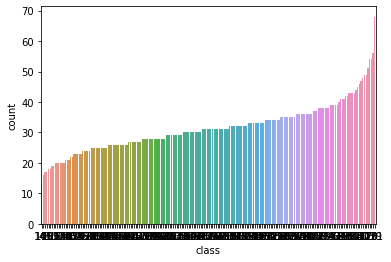

In [51]:
sns.countplot(submission["class"], order=submission["class"].value_counts(ascending=True).index)